In [1]:
# Imports and configs
%load_ext autoreload
%autoreload 2

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import loguniform, randint
import src.helpers.model_helpers as mh
import src.helpers.feature_engineering_helper as feh
import src.helpers.logistic_regression_helpers as lrh

In [2]:
# Load modeling dataset and the split indices
X_train, y_train, X_test, y_test = mh.load_model_dataset()

Loading dataset from /Users/c1burns/Documents/UTD/BUAN 6341/project_repo/data/processed/hmda_2024_model.parquet


In [3]:
# Log transform skewed continuous features prior to scaling
X_train = feh.log_transform_skewed_features(X_train)
X_test = feh.log_transform_skewed_features(X_test)

In [4]:
# Scale numeric features prior to training
lrh.scale_dataset(X_train)
lrh.scale_dataset(X_test)

,loan_amount,income,combined_loan_to_value_ratio,loan_term,intro_rate_period,prepayment_penalty_term,property_value
4048597,0.531789,0.076205,0.325896,0.470346,-0.162348,0.077177,0.035049
5573908,0.314341,-0.372218,0.700523,0.470346,-0.162348,0.077177,-0.506020
2074066,-0.078076,-0.160420,-0.583604,-0.990667,-0.162348,0.077177,0.884289
4749255,1.195145,0.177574,0.700523,0.470346,-0.162348,0.077177,0.692219
5863718,0.354053,0.114174,0.301038,-0.260161,-0.162348,0.077177,-0.506020
...,...,...,...,...,...,...,...
4059493,-0.526748,-1.151858,0.852714,0.470346,-0.162348,0.077177,-1.551868
7224571,-0.140138,0.565258,-1.124668,0.470346,-0.162348,0.077177,1.790152
8489849,-0.078076,0.026789,0.298504,-0.990667,-0.162348,0.077177,-0.270869
3149049,-0.353673,1.120435,0.382068,-1.721174,-0.162348,0.077177,1.019980


In [5]:
# Create and train CV search

# Base classifier
mlp_base = MLPClassifier(
    solver="adam",
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

# Hyperparameter search space
param_grid = {
    "hidden_layer_sizes": [(64,), (128,), (64, 32), (128, 64)],
    "activation": ["relu", "tanh"],
    "alpha": loguniform(1e-5, 1e-2),
    "learning_rate_init": loguniform(1e-4, 1e-2),
    "batch_size": randint(64, 512)
}

# CV config
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Search CV
search = RandomizedSearchCV(
    estimator=mlp_base,
    param_distributions=param_grid,
    n_iter=1,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setup

,estimator,MLPClassifier...ndom_state=42)
,param_distributions,"{'activation': ['relu', 'tanh'], 'alpha': <scipy.stats....t 0x129190980>, 'batch_size': <scipy.stats....t 0x129190ad0>, 'hidden_layer_sizes': [(64,), (128,), ...], ...}"
,n_iter,1
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [6]:
# Calculate F1 for validation
mh.output_cv_summary(search)

Best params: {'activation': 'relu', 'alpha': np.float64(0.0024526126311336773), 'batch_size': 334, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': np.float64(0.0036256176345762273)}
Best CV F1: 0.5844647186785389


In [7]:
# Calculate metrics
results, y_pred, y_prob = mh.calculate_test_metrics(search, X_test, y_test)

# Save metrics to CSV
mh.save_metrics_to_csv(results, "mlp_metrics_csv")

# Display metrics
print("Test Performance:")
display(results)

Test Performance:


,Score
F1,0.590574
Accuracy,0.832303
Precision,0.710363
Recall,0.505356
ROC AUC,0.843925
PR AUC,0.683642


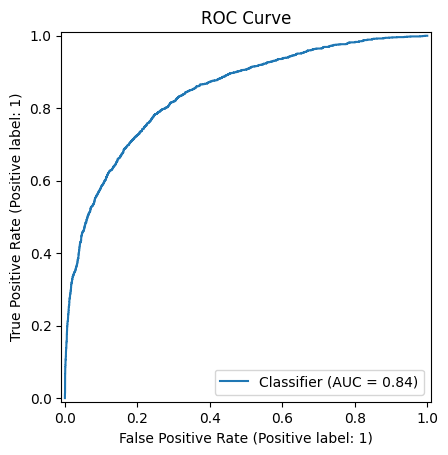

In [8]:
# ROC Curve
mh.draw_roc_curve(y_test, y_prob, "mlp_roc")

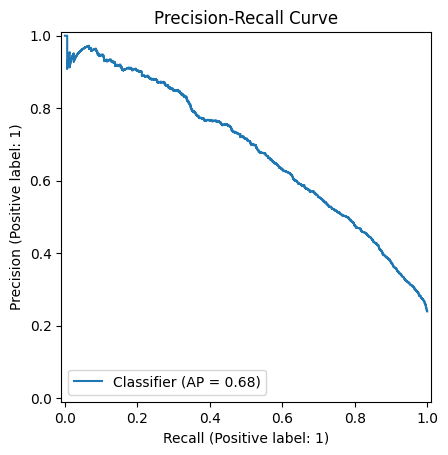

In [9]:
# PR Curve
mh.draw_pr_curve(y_test, y_prob, "mlp_pr")

In [10]:
# Persist fitted model
mh.persist_model(search, "mlp_model")

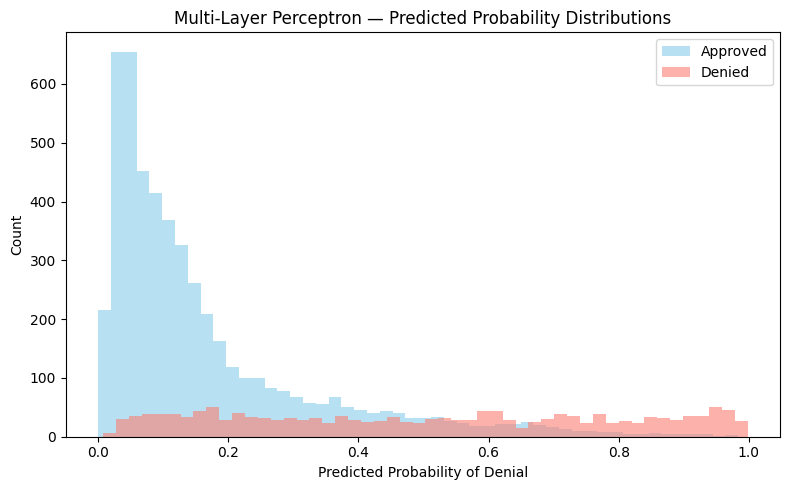

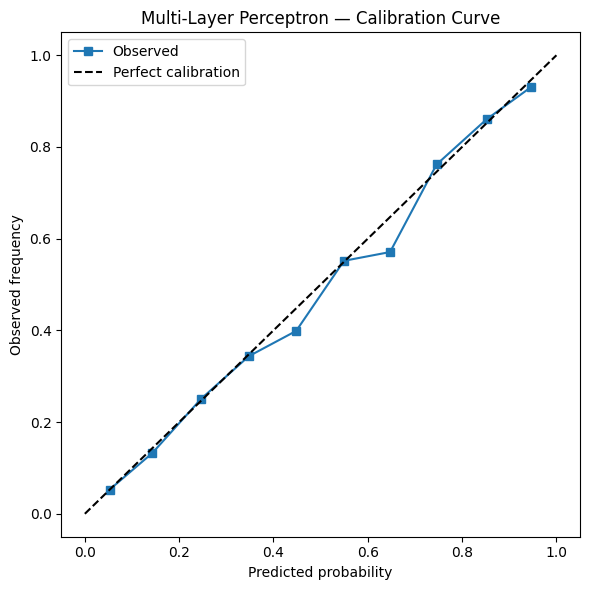

In [11]:
# Plot diagnostic charts to see how to further optimize model
mh.plot_probability_distributions(y_test, y_prob, "Multi-Layer Perceptron")
mh.plot_calibration_curve(y_test, y_prob, "Multi-Layer Perceptron")